<a href="https://colab.research.google.com/github/Alexandr-M-85/Neural-University/blob/main/%D0%A0%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

По базе машин с ЮЛЫ данным обучите модель для предсказания цен на машины.

1. Создайте обучающую, тестовую и проверочную выборки. 

2. Оцените качество работы созданной сети, определив средний процент ошибки на проверочной выборке. (Для этого потребуется привести предсказанные моделью значения к первоначальному диапазону цен.)  

3. Подсчитайте ошибку на каждом примере тестовой выборки и суммарный процент ошибки.


Рекомендации:
- в качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse).
- метрику для данной задачи можно не использовать.
- последний слой модели должен иметь 1 нейрон.
- суммарный процент ошибки = средний модуль ошибки (MAE) / среднюю цену машины. Например, если средняя цена машины 560.000 р, а средняя ошибка 56.000р, то процент ошибки равен 10%.


In [ ]:
# Загрузка датафрейма из google облака
import gdown

gdown.download('https://storage.googleapis.com/datasets_ai/Base/10_regression/cars_new.csv', None, quiet=True)

'cars_new.csv'

In [ ]:
# Ваше решение
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, concatenate, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
from tensorflow.keras import utils

In [ ]:
# загружаем базу
data = pd.read_csv('/content/cars_new.csv')
data

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0
...,...,...,...,...,...,...,...,...,...,...
70114,skoda,fabia 5j [рестайлинг],310000,2011,165000,хетчбэк,механика,бензин,1.2,70.0
70115,ford,focus 3 поколение,400000,2011,125000,хетчбэк,механика,бензин,1.6,105.0
70116,mazda,cx-5 1 поколение,1140000,2013,89981,кроссовер,автомат,бензин,2.0,150.0
70117,toyota,bb 2 поколение,550550,2006,183000,минивэн,автомат,бензин,1.3,92.0


In [ ]:
# посмотрим пропуски
data.isnull().sum()

mark       0
model      0
price      0
year       0
mileage    0
body       3
kpp        4
fuel       0
volume     0
power      0
dtype: int64

In [ ]:
# посмортим пропуски в типе кузова
data[data.body.isnull()]

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
12236,volkswagen,golf,325000,2005,140000,NaN,автомат,бензин,1.6,102.0
60368,mitsubishi,lancer,268000,2005,121000,NaN,механика,бензин,1.6,98.0
68439,audi,a5 8t [рестайлинг],949900,2013,119000,NaN,автомат,бензин,2.0,211.0


In [ ]:
# заполним пропуски в типе кузова
data.iloc[12236, 5] = 'хетчбэк'
data.iloc[60368, 5] = 'седан'
data.iloc[68439, 5] = 'купе'
data[data.body.isnull()]

,mark,model,price,year,mileage,body,kpp,fuel,volume,power


In [ ]:
data[data.kpp.isnull()]

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
768,skoda,yeti 1 поколение,675000,2012,96472,кроссовер,NaN,бензин,1.2,105.0
33857,ford,focus 3 поколение,529000,2012,59000,универсал,NaN,бензин,1.6,105.0
46153,volkswagen,passat b6,499000,2006,156000,седан,NaN,бензин,2.0,140.0
55033,ford,fiesta 6 поколение [рестайлинг],589000,2016,57000,седан,NaN,бензин,1.6,105.0


In [ ]:
# заполним все пропуки на тип кпп "механика"
data.loc[data.kpp.isnull(), 'kpp'] = 'механика'
data[data.kpp.isnull()]

,mark,model,price,year,mileage,body,kpp,fuel,volume,power


In [ ]:
data_text = data['model'].values
len(data_text) 

70119

In [ ]:
# преобразование текстовых данных в числовой
tokenizer = Tokenizer(num_words=2000,
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0',
                      oov_token='unknown')

tokenizer.fit_on_texts(data_text)
# Переводим в Эмбеддинг пространство
Sequences = tokenizer.texts_to_sequences(data_text)

# Вариант  Bag of Words
xBOW_text = tokenizer.sequences_to_matrix(Sequences)

In [ ]:
# Создаём словарь для колонок с названиями моделей, типом КПП и типом топлива
def create_dict(s):
    # Создаём пустой словарь
    ret = {}
    # Проходим по всем парам - id и название
    for _id, name in enumerate(s):
        # Добавляем в словарь
        ret.update({name: _id})
    return ret

# Функция преобразования в one hot encoding
def to_ohe(value, d):
    arr = [0] * len(d)
    arr[d[value]] = 1
    return arr

In [ ]:
# Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(data['mark']))
bodies_dict = create_dict(set(data['body']))
kpps_dict = create_dict(set(data['kpp']))
fuels_dict = create_dict(set(data['fuel']))

# Запоминаем цены
prices = np.array(data['price'], dtype=np.float)

# Введем новые переменные для нормализованных значений колонок с пробегом, объемом двигателя, мощностью двигателя и годом выпуска
years = scale(data['year'])
mileages = scale(data['mileage'])
volumes = scale(data['volume'])
powers = scale(data['power'])

In [ ]:
# Создаём пустую обучающую выборку
x_train = []
y_train = []

# Проходим по всем машинам
for _id, data in enumerate(np.array(data)):
    # В y_train добавляем цену
    y_train.append(prices[_id])

    # В x_train объединяем все параметры
    x_tr = to_ohe(data[0], marks_dict) + to_ohe(data[5], bodies_dict) + \
            to_ohe(data[6], kpps_dict) + to_ohe(data[7], fuels_dict) + \
            [years[_id]] + [mileages[_id]] + [volumes[_id]] + [powers[_id]]

    # Добавляем текущую строку в общий x_train
    x_train.append(x_tr)

# Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=np.float)
y_train = np.array(y_train, dtype=np.float)

In [ ]:
# Выводим размеры выборок
print(xBOW_text.shape)
print(x_train.shape)
print(y_train.shape)

(70119, 2000)
(70119, 50)
(70119,)


In [ ]:
# выделим часть датасета на проверку
xBOW_text_train = xBOW_text[:63000]
xBOW_text_test = xBOW_text[63000:]
xTrain = x_train[:63000]
xTest = x_train[63000:]
yTrain = y_train[:63000]
yTest = y_train[63000:]

print(xBOW_text_train.shape)
print(xTrain.shape)
print(yTrain.shape)
print(xBOW_text_test.shape)
print(xTest.shape)
print(yTest.shape)

(63000, 2000)
(63000, 50)
(63000,)
(7119, 2000)
(7119, 50)
(7119,)


In [ ]:
# Нормализуем yTrain
scaler = StandardScaler()
yTrain_scaled = scaler.fit_transform(yTrain.reshape(-1,1)).flatten()

Epoch 1/40
837/837 [==============================] - 3s 3ms/step - loss: 0.1948 - val_loss: 0.1167
Epoch 2/40
837/837 [==============================] - 2s 2ms/step - loss: 0.1448 - val_loss: 0.1049
Epoch 3/40
837/837 [==============================] - 2s 2ms/step - loss: 0.1286 - val_loss: 0.0726
Epoch 4/40
837/837 [==============================] - 2s 2ms/step - loss: 0.1131 - val_loss: 0.0944
Epoch 5/40
837/837 [==============================] - 2s 2ms/step - loss: 0.1061 - val_loss: 0.0778
Epoch 6/40
837/837 [==============================] - 2s 2ms/step - loss: 0.0904 - val_loss: 0.0826
Epoch 7/40
837/837 [==============================] - 2s 2ms/step - loss: 0.0867 - val_loss: 0.0784
Epoch 8/40
837/837 [==============================] - 2s 2ms/step - loss: 0.0825 - val_loss: 0.0715
Epoch 9/40
837/837 [==============================] - 2s 2ms/step - loss: 0.0854 - val_loss: 0.0654
Epoch 10/40
837/837 [==============================] - 2s 2ms/step - loss: 0.0806 - val_loss: 0.0685

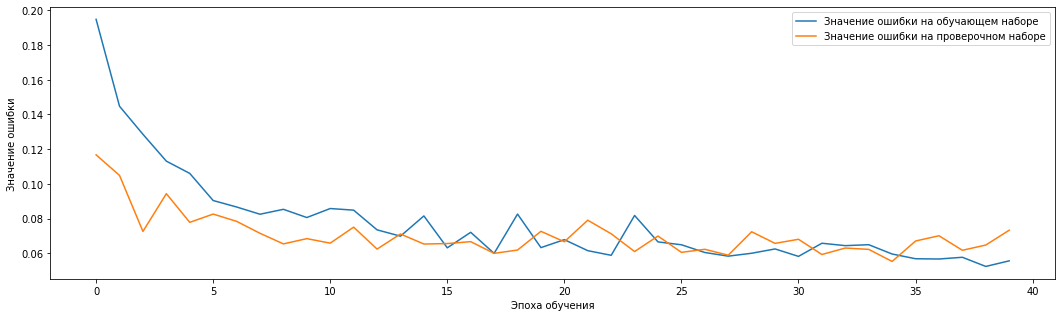

In [ ]:
# модель
input1 = Input((xTrain.shape[1],))
input2 = Input((xBOW_text_train.shape[1],))

x1 = input1                                  # Ветка 1
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(256, activation="relu")(x1)

x2 = input2                                  # Ветка 2
x2 = Dense(32, activation="relu")(x2)
x2 = Dense(64, activation="relu")(x2)
# x2 = Dropout(0.2)(x2)

x = concatenate([x1, x2])                    # Объединяем ветки

x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='linear')(x)         # Финальный регрессирующий нейрон

model_final = Model((input1, input2), x)

model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

history = model_final.fit([xTrain, xBOW_text_train], yTrain_scaled, batch_size=64,   # обучаем модель
                          epochs=40, validation_split=0.15)

# выведем графики обучения
# Создание полотна для рисунка
plt.figure(figsize=(18, 5))
# Отрисовка графиков 'loss' и 'val_loss'
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
# Фиксация графиков и рисование всей картинки
plt.show()

In [ ]:
# Предсказываем проверочную выборку
predict = model_final.predict([xTest, xBOW_text_test])
# Меняем масштаб обратно от нормированного к оригинальному
predict = scaler.inverse_transform(predict).flatten()

# Считаем среднюю цену, среднюю ошибку и средний процент ошибки
mean_delta = np.mean(abs(predict - yTest))
mean_price = np.mean(yTest)
print('Средняя ошибка: ', round(mean_delta))
print('Средняя цена: ', round(mean_price))
print('Средний процент ошибки: ', round(100*mean_delta/mean_price), '%', sep='')

Средняя ошибка:  69749
Средняя цена:  531030
Средний процент ошибки: 13%
